In [64]:
from typing import Tuple

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import pandas as pd
import scipy.stats as st

from src.get_project_data import housing_data, locale_data
pd.options.mode.chained_assignment = None  # default='warn'  # Hide SettingWithCopyWarning

In [2]:
housing_df = housing_data()
locale_df = locale_data()

In [6]:
housing_df = housing_df[["date", "zipcode", "zip_name", "pending_listing_count", "active_listing_count", "new_listing_count", "total_listing_count"]]
print(housing_df.shape)
df_full = housing_df.merge(locale_df, how='left', on="zipcode")
# A blank is 0 for pending_listing_count
df_full[["pending_listing_count", "active_listing_count", "new_listing_count", "total_listing_count"]].fillna(0, inplace=True)
print(df_full.shape)
df_full.sample(10)

(134947, 7)
(134947, 8)


,date,zipcode,zip_name,pending_listing_count,active_listing_count,new_listing_count,total_listing_count,LOCALE
30056,2021-09-01,75936,"chester, tx",2,2,2,3,43
55195,2020-06-01,75219,"dallas, tx",72,280,104,350,11
57570,2020-04-01,78537,"donna, tx",0,41,2,41,41
55129,2020-06-01,76365,"henrietta, tx",4,12,8,15,42
133694,2016-07-01,75063,"irving, tx",62,97,72,162,11
91792,2018-08-01,75253,"dallas, tx",13,11,16,23,11
29768,2021-09-01,77067,"houston, tx",20,11,12,31,21
6861,2022-11-01,75229,"dallas, tx",27,86,28,111,11
1301,2023-03-01,75852,"midway, tx",3,4,2,7,42
62342,2020-02-01,78560,"la joya, tx",0,18,4,18,41


In [7]:
by_month_totals = df_full.groupby("date")\
                         .agg({"pending_listing_count": "sum",
                               "active_listing_count": "sum",
                               "new_listing_count": "sum",
                               "total_listing_count": "sum"})\
                         .rename(columns={"pending_listing_count": "Pending Totals",
                                          "active_listing_count": "Active Listings Totals",
                                          "new_listing_count": "New Listings Totals",
                                          "total_listing_count": "Total Listings"})
by_month_totals.head()

,Pending Totals,Active Listings Totals,New Listings Totals,Total Listings
date,,,,
2016-07-01,42224,95539,38244,137312
2016-08-01,40987,96952,34864,137378
2016-09-01,37550,95516,30326,132516
2016-10-01,34867,94079,30260,128635
2016-11-01,33618,92034,25138,125142


In [13]:
df_grouped = df_full.groupby(["date", "LOCALE"])\
                    .agg({"pending_listing_count": "sum",
                          "active_listing_count": "sum",
                          "new_listing_count": "sum",
                          "total_listing_count": "sum"})
df_grouped["Pending %"] = df_grouped["pending_listing_count"] / by_month_totals["Pending Totals"] * 100
df_grouped["Active Listing %"] = df_grouped["active_listing_count"] / by_month_totals["Active Listings Totals"] * 100
df_grouped["New Listing %"] = df_grouped["new_listing_count"] / by_month_totals["New Listings Totals"] * 100
df_grouped["Total Listing %"] = df_grouped["total_listing_count"] / by_month_totals["Total Listings"] * 100
df_grouped.head(11)

pending_listing_count  active_listing_count  \
date       LOCALE                                                
2016-07-01 11                      11139                 19396   
           12                       1440                  4238   
           13                        210                   670   
           21                      10467                 15516   
           22                        717                  1198   
           23                         14                    66   
           31                        159                   397   
           32                          6                    17   
           41                      12823                 29806   
           42                       4862                 20698   
           43                        385                  3519   

                   new_listing_count  total_listing_count  Pending %  \
date       LOCALE                                                      
2016-07-01 11                   9276                30500  26.380731   
           12                   1892                 5650   3.410383   
           13                    336                  879   0.497347   
           21                   8668                25955  24.789219   
           22                    696                 1879   1.698086   
           23                     24                   78   0.033156   
           31                    148                  549   0.376563   
           32                      0                   22    0.01421   
           41                  11506                42519  30.368984   
           42                   5184                25390  11.514778   
           43                    510                 3872   0.911804   

                   Active Listing %  New Listing %  Total Listing %  
date       LOCALE                                                    
2016-07-01 11             20.301657      24.254785        22.212188  
           12              4.435885       4.947181         4.114717  
           13              0.701284       0.878569         0.640148  
           21             16.240488      22.664993        18.902208  
           22              1.253938       1.819893         1.368416  
           23              0.069082       0.062755         0.056805  
           31              0.415537       0.386989         0.399819  
           32              0.017794            0.0         0.016022  
           41             31.197731      30.085765        30.965247  
           42             21.664451      13.555067        18.490736  
           43              3.683313       1.333543         2.819856

In [9]:
# Plotting setup
# plot_df = df_grouped.drop("pending_listing_count", axis=1)
land_color_list = ["#eb348c", "#fc4eda", "#e880ff",  # urban
                   "#ff9a26", "#fac852", "#fff759",  # suburban
                   "#1a2ca3", "#5477de", "#6cade6",  # town
                   "#85ed7b", "#59c24f", "#2e8f25",  # rural
                   ]
land_labels = ["Urban Large", "Urban Midsize", "Urban Small",
               "Suburban Large", "Suburban Midsize", "Suburban Small",
               "Town Fringe", "Town Distant", "Town Remote",
               "Rural Fringe", "Rural Distant", "Rural Remote",]

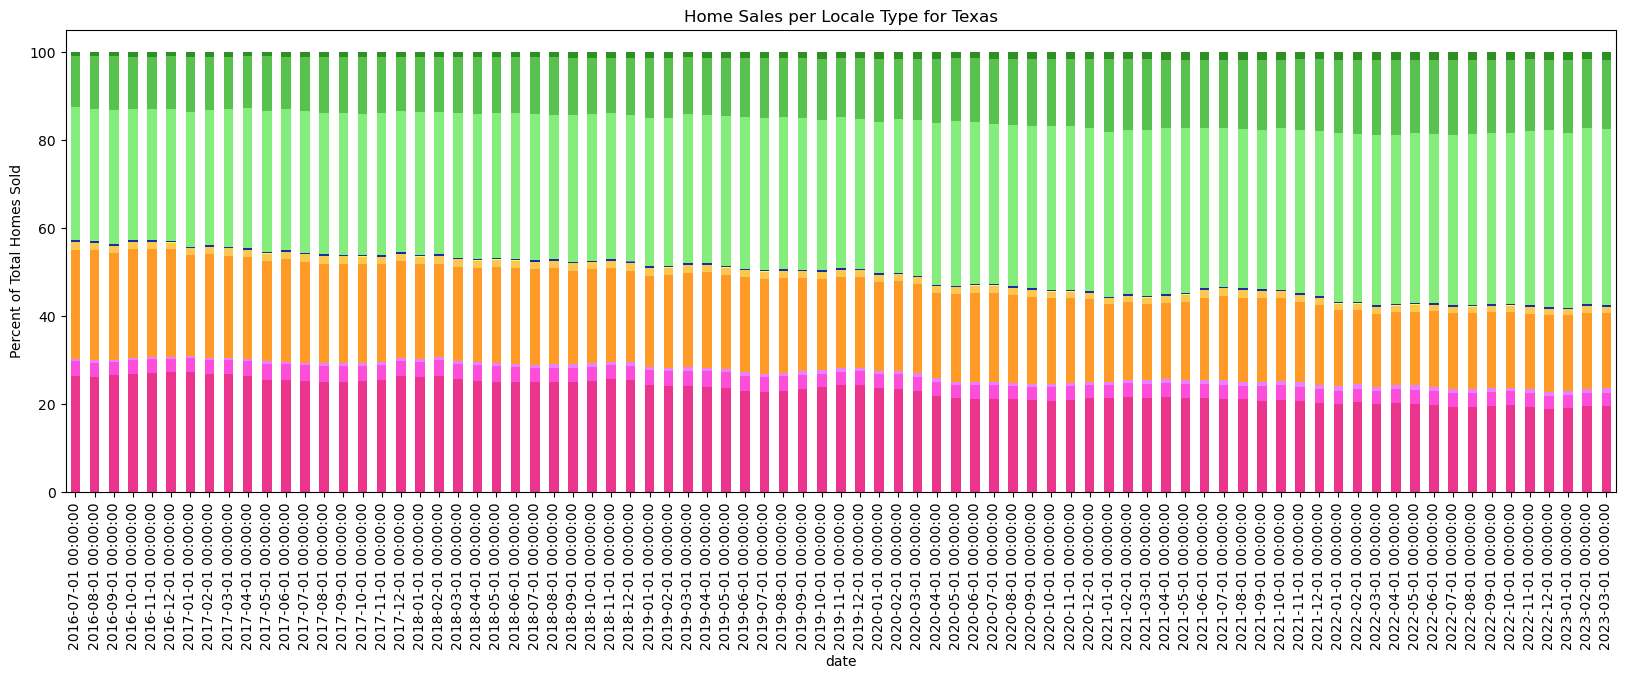

In [65]:
# fig, ax = plt.subplots(figsize=(20, 6))
# this only works with just pending totals in df (drop other columns)
# plot_df.unstack().plot.bar(ax=ax, stacked=True, color=land_color_list, legend=False)
# # ax.bar(x=plot_df.unstack().index, stacked=True)
# ax.set(ylabel="Percent of Total Homes Sold", title="Home Sales per Locale Type for Texas")
# # ax.xaxis.set_major_locator(YearLocator())
# # ax.xaxis.set_major_formatter(DateFormatter("%Y"))
# # ax.xaxis.set_major_locator(YearLocator(month=1))
# # ax.xaxis.set_major_formatter(DateFormatter("%y-%m"))
# # fig.autofmt_xdate()
# plt.show()

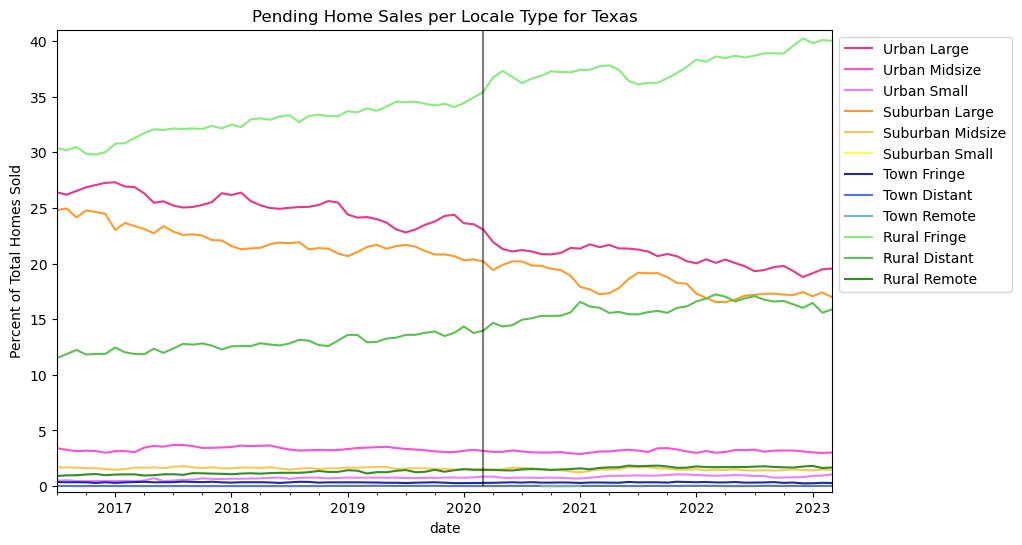

In [193]:
fig, ax = plt.subplots(figsize=(10, 6))
df_grouped.unstack().plot.line(ax=ax, y="Pending %", color=land_color_list)
ax.set(ylabel="Percent of Total Homes Sold", title="Pending Home Sales per Locale Type for Texas")
ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(pd.Timestamp(year=2020, month=3, day=13), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.set_ylim(-0.5, 41)
plt.show()

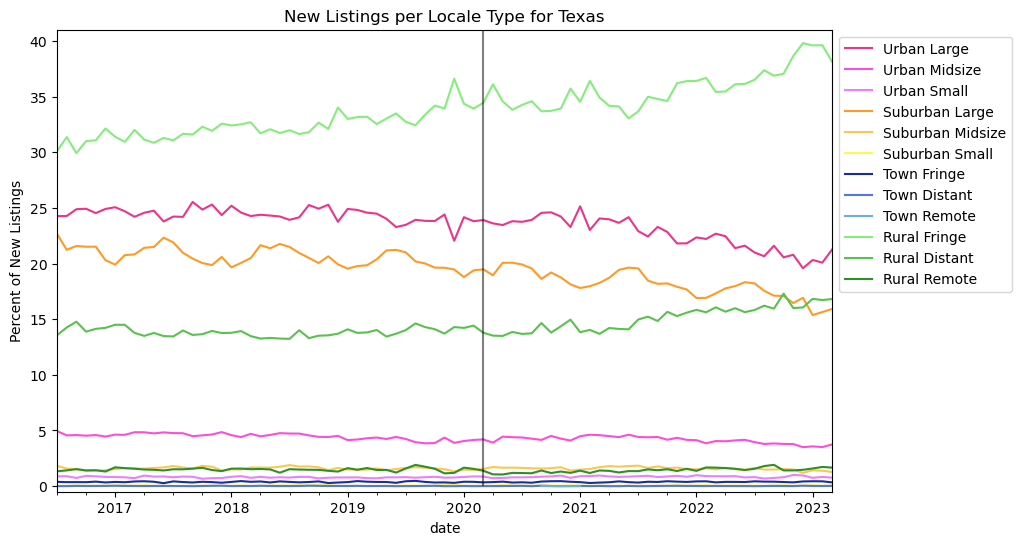

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
df_grouped.unstack().plot.line(ax=ax, y="New Listing %", color=land_color_list)
ax.set(ylabel="Percent of New Listings", title="New Listings per Locale Type for Texas")
ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(pd.Timestamp(year=2020, month=3, day=13), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.set_ylim(-0.5, 41)
plt.show()

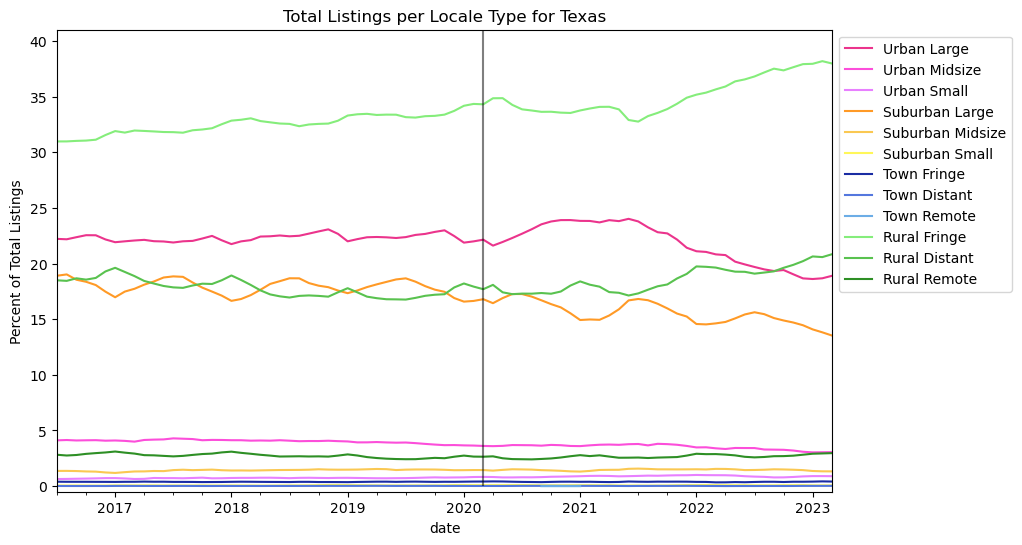

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
df_grouped.unstack().plot.line(ax=ax, y="Total Listing %", color=land_color_list)
ax.set(ylabel="Percent of Total Listings", title="Total Listings per Locale Type for Texas")
ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(pd.Timestamp(year=2020, month=3, day=13), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.set_ylim(-0.5, 41)
plt.show()

## Regressions

In [139]:
# for regression and plotting with matplotlib, dates need to be a number, we will use ordinal
df_linear_regress_data = df_grouped.reset_index()
df_linear_regress_data["date"] = df_linear_regress_data["date"].apply(pd.Timestamp.toordinal)

# Dates
DATE_START = "2016-7-1"
DATE_END = "2023-3-1"
COVID_START_TX = "2020-3-13"
TS_COVID_START_TX = pd.Timestamp(COVID_START_TX)
COVID_PLUS_1_YEAR = "2021-4-1"
TS_COVID_PLUS_1_YEAR = pd.Timestamp(COVID_PLUS_1_YEAR)

# linespace for plotting linear regressions
ls_before_covid = pd.date_range(DATE_START, COVID_START_TX, freq="MS").to_series(name="date").apply(pd.Timestamp.toordinal).reset_index(drop=True)
ls_after_covid = pd.date_range(COVID_PLUS_1_YEAR, DATE_END, freq="MS").to_series(name="date").apply(pd.Timestamp.toordinal).reset_index(drop=True)
ls_full = pd.date_range(DATE_START, DATE_END, freq="MS").to_series(name="date").apply(pd.Timestamp.toordinal).reset_index(drop=True)

In [123]:
def linear_regression_per_locale(data: pd.DataFrame, column: str, locale: int) -> Tuple[float]:
    # assume data as "date" as ordinal Int and "LOCALE" as Int columns
    _data_df = data.loc[data["LOCALE"] == locale, [column, "date"]]
    _data_df = _data_df.astype(float)  # Fixes strange error AttributeError
    return st.linregress(_data_df["date"], _data_df[column])

In [140]:
pre_covid_data = df_linear_regress_data.loc[df_linear_regress_data["date"] < TS_COVID_START_TX.toordinal(), :]
post_covid_data = df_linear_regress_data.loc[df_linear_regress_data["date"] >= TS_COVID_PLUS_1_YEAR.toordinal(), :]
print("Pre Covid data shape:", pre_covid_data.shape)
print("During/After Covid data shape:", post_covid_data.shape)

Pre Covid data shape: (495, 10)
During/After Covid data shape: (264, 10)


In [205]:
def plot_regressions(ax: plt.Axes, base_data: pd.DataFrame,
                     base_color: str, locale: int, column: str,
                     pre_line_color: str, post_line_color: str,
                     useFullRegression: bool = True,
                     extendPreCovidRegression: bool = False):
    # Calculate Regressions
    regress_pre = linear_regression_per_locale(pre_covid_data, column, locale)
    regress_post = linear_regression_per_locale(post_covid_data, column, locale)
    
    # Plot regressions and base line
    ax.plot(base_data.loc[base_data["LOCALE"] == locale, "date"],
            base_data.loc[base_data["LOCALE"] == locale, column], color=base_color)
    # pre covid regression plot
    if extendPreCovidRegression:  # plot over full extent of graph
        ax.plot(ls_full, regress_pre.slope * ls_full + regress_pre.intercept, color=pre_line_color, linestyle="dotted")
    else:  # plot only up to Covid Start
        ax.plot(ls_before_covid, regress_pre.slope * ls_before_covid + regress_pre.intercept, color=pre_line_color, linestyle="dotted")
    # post covid regression plot
    ax.plot(ls_after_covid, regress_post.slope * ls_after_covid + regress_post.intercept, color=post_line_color, linestyle="dotted")

    if useFullRegression:
        regress_full = linear_regression_per_locale(df_linear_regress_data, column, locale)
        ax.plot(ls_full, regress_full.slope * ls_full + regress_full.intercept, color=base_color, linestyle="dashed", alpha=0.5)

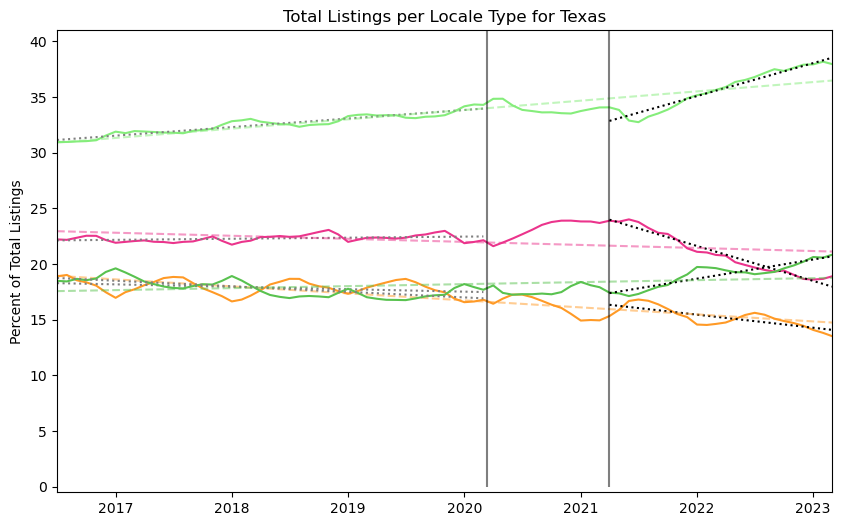

In [207]:
# Add regression lines
fig, ax = plt.subplots(figsize=(10, 6))
plot_regressions(ax, df_linear_regress_data, "#85ed7b", 41, "Total Listing %", "gray", "black")
plot_regressions(ax, df_linear_regress_data, "#eb348c", 11, "Total Listing %", "gray", "black")
plot_regressions(ax, df_linear_regress_data, "#ff9a26", 21, "Total Listing %", "gray", "black")
plot_regressions(ax, df_linear_regress_data, "#59c24f", 42, "Total Listing %", "gray", "black")
ax.set(ylabel="Percent of Total Listings", title="Total Listings per Locale Type for Texas")
# ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(TS_COVID_START_TX.toordinal(), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.vlines(TS_COVID_PLUS_1_YEAR.toordinal(), colors='black', ymin=0, ymax=41, label="1 Year Later", alpha=.50)
ax.set_ylim(-0.5, 41)
# set ticks on year start and display as string, not ordinal
ax.set_xlim(pd.Timestamp("2016-7-1").toordinal(), pd.Timestamp("2023-3-1").toordinal())
dates = ["2017", "2018", "2019", "2020", "2021", "2022", "2023"]  # Will automatically be set to 1st day of the year
ax.set_xticks(pd.to_datetime(dates, format="%Y").to_series().apply(pd.Timestamp.toordinal), labels=dates)
plt.show()

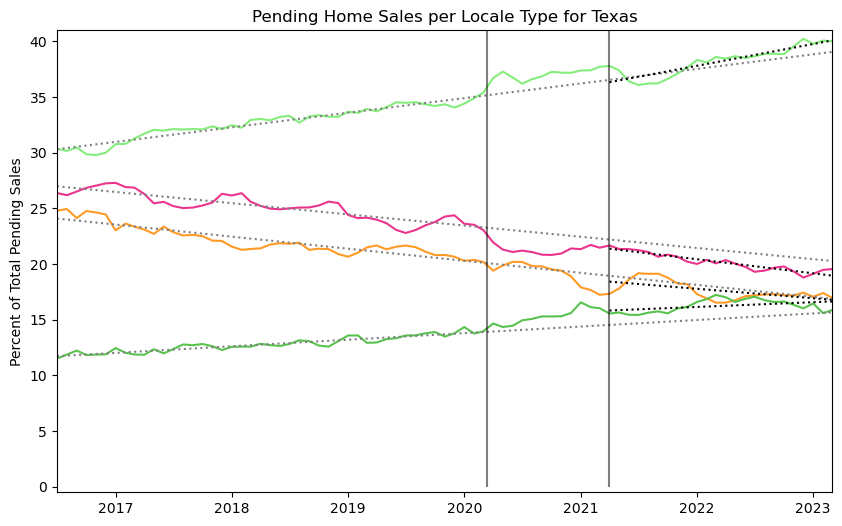

In [208]:
# Add regression lines
fig, ax = plt.subplots(figsize=(10, 6))
plot_regressions(ax, df_linear_regress_data, "#85ed7b", 41, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
plot_regressions(ax, df_linear_regress_data, "#eb348c", 11, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
plot_regressions(ax, df_linear_regress_data, "#ff9a26", 21, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
plot_regressions(ax, df_linear_regress_data, "#59c24f", 42, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
ax.set(ylabel="Percent of Total Pending Sales", title="Pending Home Sales per Locale Type for Texas")
# ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(TS_COVID_START_TX.toordinal(), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.vlines(TS_COVID_PLUS_1_YEAR.toordinal(), colors='black', ymin=0, ymax=41, label="1 Year Later", alpha=.50)
ax.set_ylim(-0.5, 41)
# set ticks on year start and display as string, not ordinal
ax.set_xlim(pd.Timestamp("2016-7-1").toordinal(), pd.Timestamp("2023-3-1").toordinal())
dates = ["2017", "2018", "2019", "2020", "2021", "2022", "2023"]  # Will automatically be set to 1st day of the year
ax.set_xticks(pd.to_datetime(dates, format="%Y").to_series().apply(pd.Timestamp.toordinal), labels=dates)
plt.show()

In [212]:
def regression_summary(regress_df_column: str, calculate_tuple: Tuple[Tuple[str, int]]) -> pd.DataFrame:
    """Create a table of slopes and r-values for Pre, Post, Full linear regressions

    :param regress_df_column: column from linear_regression dataFrame to use
    :param calculate_tuple: tuple of tuples containing Locale name and Locale int
    :return: summary data frame with row for each item in `calculate_tuple`
    """
    lin_regress_summary = []
    for locale_type in calculate_tuple:
        regress_pre = linear_regression_per_locale(pre_covid_data, regress_df_column, locale_type[1])
        regress_post = linear_regression_per_locale(post_covid_data, regress_df_column, locale_type[1])
        regress_full = linear_regression_per_locale(df_linear_regress_data, regress_df_column, locale_type[1])
        line_summary = {"Pre Slope": regress_pre.slope,
                        "Pre r-value": regress_pre.rvalue,
                        "Post Slope": regress_post.slope,
                        "Post r-value": regress_post.rvalue,
                        "Full Slope": regress_full.slope,
                        "Full r-value": regress_full.rvalue}
        lin_regress_summary.append(line_summary)
    df_regress_summary = pd.DataFrame(lin_regress_summary, index=[item[0] for item in calculate_tuple])
    return df_regress_summary

In [213]:
locales_to_calculate = (("Rural Distant", 42), ("Rural Fringe", 41), ("Suburban Large", 21), ("Urban Large", 11))
regression_summary("Pending %", locales_to_calculate)

,Pre Slope,Pre r-value,Post Slope,Post r-value,Full Slope,Full r-value
Rural Distant,0.001616,0.932280,0.001166,0.432908,0.002299,0.959896
Rural Fringe,0.003591,0.966682,0.005367,0.903799,0.003958,0.979939
Suburban Large,-0.002966,-0.910672,-0.002332,-0.607583,-0.003153,-0.965015
Urban Large,-0.002756,-0.885396,-0.003460,-0.936311,-0.003445,-0.970179


Slopes of post covid vs pre covid are almost exactly the same

In [214]:
regression_summary("Total Listing %", locales_to_calculate)

,Pre Slope,Pre r-value,Post Slope,Post r-value,Full Slope,Full r-value
Rural Distant,-0.001365,-0.713422,0.004723,0.916702,0.000491,0.346195
Rural Fringe,0.002104,0.945815,0.008116,0.967132,0.002291,0.896267
Suburban Large,-0.000597,-0.347973,-0.003219,-0.778924,-0.001724,-0.857986
Urban Large,0.000264,0.337118,-0.008597,-0.979864,-0.000750,-0.406319


Slopes for Total Listing % Have a significant change 1 year into Covid. All 4 above get steeper